In [298]:

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import os
import torch
import dill as pickle


stage1_model_path = os.path.join(save_folder, 'stage1_model.pkl')
stage2_model_path = os.path.join(save_folder, 'stage2_model.pkl')

with open(stage1_model_path, 'rb') as f:
    stage1_model = torch.load(f, pickle_module=pickle)

with open(stage2_model_path, 'rb') as f:
    stage2_model = torch.load(f, pickle_module=pickle)





In [299]:
# Function to handle the forward pass for two-stage models
def get_model_outputs_stage1_stage2(model_stage1, model_stage2, device, X):
    model_stage1.to(device)
    model_stage2.to(device)
    model_stage1.eval()
    model_stage2.eval()

    with torch.no_grad():
        X = X.to(device)

        # Stage 1 forward pass
        out1 = model_stage1(X)
        # Stage 2 forward pass - requires both X and stage 1 output
        out2 = model_stage2(X, out1)


    return out1.cpu().numpy(), out2.cpu().numpy()



In [300]:
T_TAS5=np.arange(1.5,12)
Hs_TAS5=np.arange(4.75,0,-0.5)
sea_state_TAS5 = np.array([
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 4, 4, 1, 0, 0, 0, 0],
    [0, 0, 0, 4, 11, 9, 3, 0, 0, 0, 0],
    [0, 0, 1, 15, 27, 18, 6, 1, 0, 0, 0],
    [0, 0, 11, 51, 67, 40, 14, 3, 0, 0, 0],
    [0, 2, 62, 162, 165, 90, 33, 7, 1, 0, 0],
    [0, 36, 232, 426, 374, 208, 81, 21, 5, 0, 0],
    [16, 178, 527, 805, 712, 394, 178, 74, 20, 3, 0],
    [28, 200, 476, 688, 626, 358, 197, 136, 62, 9,2],
    [13, 57, 130, 187, 171, 110, 78, 78, 46, 7,2]
])

T_TAS2=np.arange(3.5,13)
Hs_TAS2=np.arange(6.75,0.5,-0.5)
sea_state_TAS2 = np.array([
    [0, 0, 0, 1, 7, 16, 15, 5, 0, 0],
    [0, 0, 0, 3, 16, 32, 28, 10, 1, 0],
    [0, 0, 1, 10, 34, 57, 45, 15, 2, 0],
    [0, 0, 4, 25, 70, 98, 67, 21, 3, 0],
    [0, 0, 11, 50, 122, 153, 95, 28, 4, 0],
    [0, 3, 23, 88, 195, 226, 129, 36, 6, 0],
    [0, 8, 41, 139, 284, 307, 169, 49, 8, 0],
    [1, 18, 59, 190, 381, 383, 202, 65, 13, 1],
    [4, 24, 67, 244, 478, 439, 216, 74, 18, 2],
    [6, 21, 61, 273, 504, 421, 197, 71, 20, 3],
    [4, 12, 44, 209, 359, 273, 122, 46, 14, 3],
    [1, 4, 18, 84, 132, 89, 36, 14, 4, 0],
    [0, 0, 3, 12, 15, 8, 3, 1, 0, 0],

])

T_VIC2=np.array(np.arange(3.5,13))
Hs_VIC2=np.array(np.arange(6.75,0.5,-0.5))
sea_state_VIC2 = np.array([
    [0, 0, 0, 0, 1, 4, 5, 2, 0, 0],
    [0, 0, 0, 0, 4, 10, 11, 4, 0, 0],
    [0, 0, 0, 3, 12, 23, 21, 8, 1, 0],
    [0, 0, 1, 8, 27, 48, 42, 17, 2, 0],
    [0, 0, 4, 20, 53, 86, 73, 26, 3, 0],
    [0, 1, 10, 40, 98, 150, 114, 37, 6, 0],
    [0, 6, 22, 67, 177, 257, 175, 53, 9, 0],
    [0, 15, 36, 108, 297, 397, 252, 79, 14, 1],
    [5, 25, 45, 165, 447, 538, 317, 107, 24, 3],
    [10, 24, 40, 224, 568, 611, 329, 115, 31, 5],
    [9, 14, 29, 210, 479, 459, 224, 77, 24, 5],
    [3, 4, 14, 101, 199, 162, 69, 25, 8, 2],
    [0, 0, 3, 16, 24, 13, 4, 2, 0, 0],])


In [301]:
import numpy as np
from scipy.interpolate import interp1d

def interpolate_rao(rao, Tp):

    T = np.linspace(3, 14, 36)

    if rao.shape[0] != len(T):
        raise ValueError("Shape mismatch between `rao` and `T`. Ensure `rao` has 36 rows.")
    
    interpolator = interp1d(T, rao, axis=0, kind='linear', fill_value="extrapolate")
    
    # Use the interpolator with the new custom `Tp` array
    rao_interpolated = interpolator(Tp)
    
    return rao_interpolated



In [302]:
import numpy as np

def jonswap_spectrum(Hs, Tp, omega, gamma=3.3):
    """
    Calculate the JONSWAP spectrum S_j(omega).

    Parameters:
    Hs: float
        Significant wave height.
    Tp: float
        Peak wave period.
    omega: array-like
        Angular frequencies at which to evaluate the spectrum.
    gamma: float, optional (default=3.3)
        Peak enhancement factor.

    Returns:
    S_j: array-like
        Spectral density at the given frequencies.
    """
    omega_p = 2 * np.pi / Tp  # Peak angular frequency
    # Calculate alpha
    gamma_factor = gamma
    alpha_denominator = 0.230 + 0.0336 * gamma_factor - 0.185 / (1.9 + gamma_factor)
    alpha = 0.0624 / alpha_denominator
    # Determine sigma for each omega
    sigma = np.where(omega <= omega_p, 0.09, 0.07)
    # Compute the exponent for gamma term
    exp_gamma = - ((omega - omega_p) ** 2) / (2 * sigma ** 2 * omega_p ** 2)
    gamma_term = gamma_factor ** exp_gamma
    # Compute the exponential term
    exp_term = np.exp(-1.25 * (omega_p / omega) ** 4)
    # Compute S_j(omega)
    with np.errstate(divide='ignore', invalid='ignore'):
        S_j = alpha * Hs ** 2 * (omega_p ** 4 / omega ** 5) * exp_term * gamma_term
        S_j = np.nan_to_num(S_j)
    return S_j

def Power_matrix(rao, Bpto, Hs_array, Tp_array, prob_array, constraint=np.pi/2, gamma=3.3):

    omega = 2 * np.pi / Tp_array 
    n_T,n_WEC=rao.shape
    n_H=len(Hs_array)
    P_mat=np.zeros(( n_H,n_T, n_WEC))

    rao_abs=np.abs(rao)
    omega_p=omega.reshape(n_T,1)
    omega_int=omega[::-1]
    
    
    expanded_prob = np.expand_dims(prob_array, axis=-1)  
    prob = np.repeat(expanded_prob, n_WEC, axis=-1)

    for j in range(n_T):
        for i in range(n_H):
            Hs = Hs_array[i]
            Tp = Tp_array[j]
            # Calculate the JONSWAP spectrum
            S_j = jonswap_spectrum(Hs, Tp, omega, gamma=gamma)
            
            amp=rao_abs*(Hs_array[i]/2)
            amp_c = np.where(amp > constraint, constraint, amp)
            # Compute P̄(ω) = 1/2 * Bpto * (ω * |rao|*a)^2
            P_bar_omega = 0.5 * Bpto * (omega_p * amp_c) ** 2

            for k in range(n_WEC):
                # Compute the absorbed power spectral density for each WEC
                P_mat[i,j,k]= 2 * np.trapz(S_j * P_bar_omega[:,k], omega_int)
                
        
    # Adjust power by probability
    # print(prob.shape)
    P_AAP = P_mat * prob

    return P_AAP



In [303]:

def P_AAP_site(Bpto,rao_pred, prob, Tp, Hs):

    rao = interpolate_rao(rao_pred, Tp)
    power_matrix_irregular =Power_matrix(rao, Bpto, Hs, Tp, prob, constraint=np.pi/2, gamma=3.3)
    return power_matrix_irregular.sum()



In [305]:
# case study 
# VIC2 

prob_VIC2=(sea_state_VIC2/np.sum(sea_state_VIC2))

iso,res=get_model_outputs_stage1_stage2(stage1_model, stage2_model, 'cuda', X_test_t)
rao_test=iso+res
rao_test_target=iso_test+res_test
VIC2_P_AAP_test_pred=[]
VIC2_P_AAP_test_target=[]
VIC2_q_test_pred=[]
VIC2_q_test_target=[]

for rao_iso, rao_iso_target, rao,rao_target, X_PTO in zip(iso, iso_test, rao_test,rao_test_target, X_test):
    Bpto=X_PTO[6]
    P_AAP_pred=P_AAP_site(Bpto,rao, prob_VIC2, T_VIC2, Hs_VIC2)
    P_AAP_test=P_AAP_site(Bpto,rao_target, prob_VIC2, T_VIC2, Hs_VIC2)
    VIC2_P_AAP_test_pred.append(P_AAP_pred)
    VIC2_P_AAP_test_target.append(P_AAP_test)
    
    P_AAP_iso_pred=P_AAP_site(Bpto,rao_iso, prob_VIC2, T_VIC2, Hs_VIC2)
    P_AAP_iso_test=P_AAP_site(Bpto,rao_iso_target, prob_VIC2, T_VIC2, Hs_VIC2)
    q_pred=P_AAP_pred/P_AAP_iso_pred
    q_test=P_AAP_test/P_AAP_iso_test
    
    VIC2_q_test_pred.append(q_pred)
    VIC2_q_test_target.append(q_test)



In [312]:
# case study 
# TAS5

prob_TAS5 = (sea_state_TAS5 / np.sum(sea_state_TAS5))

TAS5_P_AAP_test_pred = []
TAS5_P_AAP_test_target = []
TAS5_q_test_pred = []
TAS5_q_test_target = []

for rao_iso, rao_iso_target, rao, rao_target, X_PTO in zip(iso, iso_test, rao_test, rao_test_target, X_test):
    Bpto = X_PTO[6]
    
    # Compute P_AAP predictions and targets
    P_AAP_pred = P_AAP_site(Bpto, rao, prob_TAS5, T_TAS5, Hs_TAS5)
    P_AAP_test = P_AAP_site(Bpto, rao_target, prob_TAS5, T_TAS5, Hs_TAS5)
    
    TAS5_P_AAP_test_pred.append(P_AAP_pred)
    TAS5_P_AAP_test_target.append(P_AAP_test)
    
    # Compute P_AAP for isolated scenarios
    P_AAP_iso_pred = P_AAP_site(Bpto, rao_iso, prob_TAS5, T_TAS5, Hs_TAS5)
    P_AAP_iso_test = P_AAP_site(Bpto, rao_iso_target, prob_TAS5, T_TAS5, Hs_TAS5)
    
    # Compute q (ratio of P_AAP / P_AAP_iso)
    q_pred = P_AAP_pred / P_AAP_iso_pred
    q_test = P_AAP_test / P_AAP_iso_test
    
    TAS5_q_test_pred.append(q_pred)
    TAS5_q_test_target.append(q_test)


In [316]:
# case study 
# TAS2

prob_TAS2 = (sea_state_TAS2 / np.sum(sea_state_TAS2))

TAS2_P_AAP_test_pred = []
TAS2_P_AAP_test_target = []
TAS2_q_test_pred = []
TAS2_q_test_target = []

for rao_iso, rao_iso_target, rao, rao_target, X_PTO in zip(iso, iso_test, rao_test, rao_test_target, X_test):
    Bpto = X_PTO[6]
    
    # Compute P_AAP predictions and targets
    P_AAP_pred = P_AAP_site(Bpto, rao, prob_TAS2, T_TAS2, Hs_TAS2)
    P_AAP_test = P_AAP_site(Bpto, rao_target, prob_TAS2, T_TAS2, Hs_TAS2)
    
    TAS2_P_AAP_test_pred.append(P_AAP_pred)
    TAS2_P_AAP_test_target.append(P_AAP_test)
    
    # Compute P_AAP for isolated scenarios
    P_AAP_iso_pred = P_AAP_site(Bpto, rao_iso, prob_TAS2, T_TAS2, Hs_TAS2)
    P_AAP_iso_test = P_AAP_site(Bpto, rao_iso_target, prob_TAS2, T_TAS2, Hs_TAS2)
    
    # Compute q (ratio of P_AAP / P_AAP_iso)
    q_pred = P_AAP_pred / P_AAP_iso_pred
    q_test = P_AAP_test / P_AAP_iso_test
    
    TAS2_q_test_pred.append(q_pred)
    TAS2_q_test_target.append(q_test)


In [319]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, median_absolute_error, explained_variance_score, max_error
from scipy.stats import pearsonr
from scipy import stats
import pandas as pd

# Convert the P_AAP test predictions and targets to NumPy arrays
VIC2_P_AAP_test_pred_np = np.array(VIC2_P_AAP_test_pred)
VIC2_P_AAP_test_target_np = np.array(VIC2_P_AAP_test_target)

TAS5_P_AAP_test_pred_np = np.array(TAS5_P_AAP_test_pred)
TAS5_P_AAP_test_target_np = np.array(TAS5_P_AAP_test_target)

TAS2_P_AAP_test_pred_np = np.array(TAS2_P_AAP_test_pred)
TAS2_P_AAP_test_target_np = np.array(TAS2_P_AAP_test_target)

# Convert the q test predictions and targets to NumPy arrays
VIC2_q_test_pred_np = np.array(VIC2_q_test_pred)
VIC2_q_test_target_np = np.array(VIC2_q_test_target)

TAS5_q_test_pred_np = np.array(TAS5_q_test_pred)
TAS5_q_test_target_np = np.array(TAS5_q_test_target)

TAS2_q_test_pred_np = np.array(TAS2_q_test_pred)
TAS2_q_test_target_np = np.array(TAS2_q_test_target)

# Define additional metrics
def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))

def uncertainty_95(y_true, y_pred):
    residuals = y_true - y_pred
    se = np.std(residuals, ddof=1) / np.sqrt(len(y_true))
    return stats.t.interval(0.95, len(y_true)-1, loc=np.mean(residuals), scale=se)[1] - np.mean(residuals)

# Prepare pairs of target and prediction arrays for both P_AAP and q metrics
pairs = [
    ('VIC2_P_AAP', VIC2_P_AAP_test_target_np, VIC2_P_AAP_test_pred_np),
    ('TAS5_P_AAP', TAS5_P_AAP_test_target_np, TAS5_P_AAP_test_pred_np),
    ('TAS2_P_AAP', TAS2_P_AAP_test_target_np, TAS2_P_AAP_test_pred_np),
    ('VIC2_q', VIC2_q_test_target_np, VIC2_q_test_pred_np),
    ('TAS5_q', TAS5_q_test_target_np, TAS5_q_test_pred_np),
    ('TAS2_q', TAS2_q_test_target_np, TAS2_q_test_pred_np)
]

metrics_list = []

# Iterate over each pair and compute metrics
for name, target, pred in pairs:
    metrics = {
        'Name': name,
        'MSE': mean_squared_error(target, pred),
        'RMSE': np.sqrt(mean_squared_error(target, pred)),
        'MAE': mean_absolute_error(target, pred),
        'R2': r2_score(target, pred),
        'MedianAE': median_absolute_error(target, pred),
        'ExplainedVariance': explained_variance_score(target, pred),
        'MaxError': max_error(target, pred),
        'SMAPE': smape(target, pred),
        'Uncertainty95': uncertainty_95(target, pred),
        'PearsonR': pearsonr(target, pred)[0]
    }
    metrics_list.append(metrics)

# Create a DataFrame from the metrics list
metrics_df = pd.DataFrame(metrics_list)

# Set the Name column as the index
metrics_df.set_index('Name', inplace=True)

# Save the metrics DataFrame to a CSV file
metrics_df.to_csv('metrics_results.csv')

# Optionally, you can print a message indicating that the file has been saved
print("Metrics have been saved to 'metrics_results.csv'")


Metrics have been saved to 'metrics_results.csv'


In [318]:
metrics_df

,MSE,RMSE,MAE,R2,MedianAE,ExplainedVariance,MaxError,SMAPE,Uncertainty95,PearsonR
Name,,,,,,,,,,
VIC2_P_AAP,3.746620e+04,193.561866,102.340833,0.999961,50.651304,0.999961,2152.374004,0.157612,9.742192,0.999981
TAS5_P_AAP,2.559183e+03,50.588369,31.538296,0.999767,18.093846,0.999768,509.589083,0.469477,2.556796,0.999884
TAS2_P_AAP,5.506642e+04,234.662351,114.896372,0.999975,51.151361,0.999975,2904.537450,0.118623,11.813722,0.999988
VIC2_q,3.558213e-07,0.000597,0.000350,0.956888,0.000196,0.956915,0.005697,0.034982,0.000030,0.978226
TAS5_q,8.357352e-06,0.002891,0.001696,0.966044,0.000961,0.966054,0.023435,0.170953,0.000146,0.982976
TAS2_q,2.046819e-07,0.000452,0.000265,0.956291,0.000144,0.956418,0.004133,0.026470,0.000023,0.977979


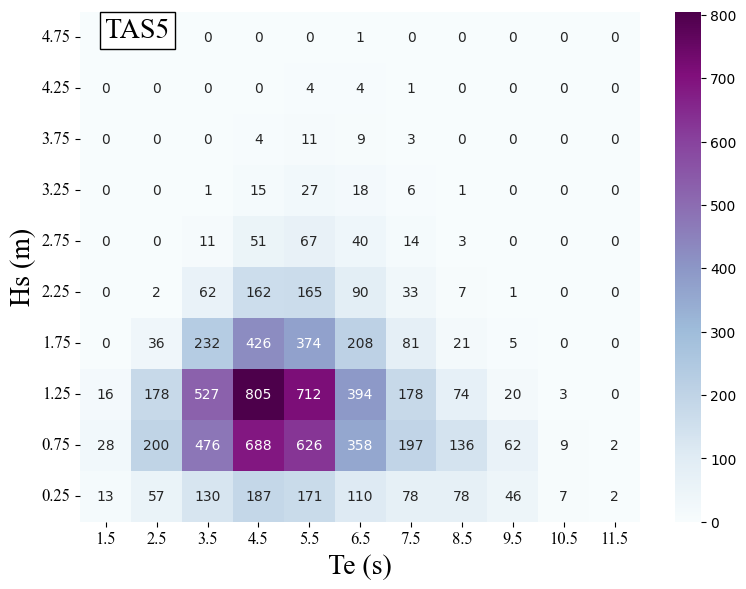

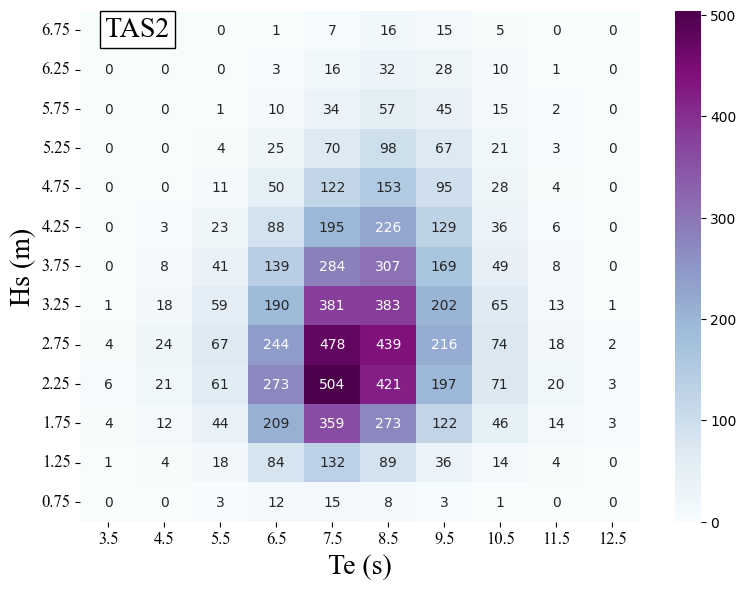

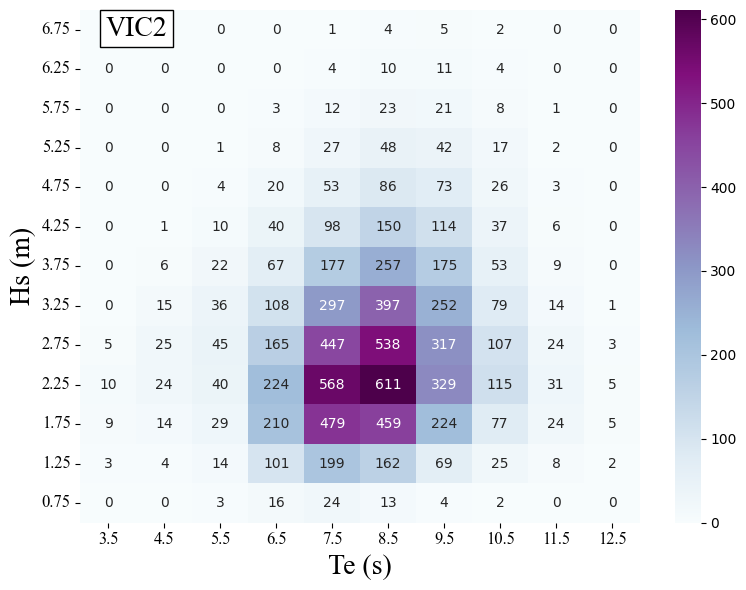

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Data Arrays
T_TAS5 = np.arange(1.5, 12)
Hs_TAS5 = np.arange(4.75, 0, -0.5)
sea_state_TAS5 = np.array([
    [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 4, 4, 1, 0, 0, 0, 0],
    [0, 0, 0, 4, 11, 9, 3, 0, 0, 0, 0],
    [0, 0, 1, 15, 27, 18, 6, 1, 0, 0, 0],
    [0, 0, 11, 51, 67, 40, 14, 3, 0, 0, 0],
    [0, 2, 62, 162, 165, 90, 33, 7, 1, 0, 0],
    [0, 36, 232, 426, 374, 208, 81, 21, 5, 0, 0],
    [16, 178, 527, 805, 712, 394, 178, 74, 20, 3, 0],
    [28, 200, 476, 688, 626, 358, 197, 136, 62, 9, 2],
    [13, 57, 130, 187, 171, 110, 78, 78, 46, 7, 2]
])

T_TAS2 = np.arange(3.5, 13)
Hs_TAS2 = np.arange(6.75, 0.5, -0.5)
sea_state_TAS2 = np.array([
    [0, 0, 0, 1, 7, 16, 15, 5, 0, 0],
    [0, 0, 0, 3, 16, 32, 28, 10, 1, 0],
    [0, 0, 1, 10, 34, 57, 45, 15, 2, 0],
    [0, 0, 4, 25, 70, 98, 67, 21, 3, 0],
    [0, 0, 11, 50, 122, 153, 95, 28, 4, 0],
    [0, 3, 23, 88, 195, 226, 129, 36, 6, 0],
    [0, 8, 41, 139, 284, 307, 169, 49, 8, 0],
    [1, 18, 59, 190, 381, 383, 202, 65, 13, 1],
    [4, 24, 67, 244, 478, 439, 216, 74, 18, 2],
    [6, 21, 61, 273, 504, 421, 197, 71, 20, 3],
    [4, 12, 44, 209, 359, 273, 122, 46, 14, 3],
    [1, 4, 18, 84, 132, 89, 36, 14, 4, 0],
    [0, 0, 3, 12, 15, 8, 3, 1, 0, 0]
])

T_VIC2 = np.array(np.arange(3.5, 13))
Hs_VIC2 = np.array(np.arange(6.75, 0.5, -0.5))
sea_state_VIC2 = np.array([
    [0, 0, 0, 0, 1, 4, 5, 2, 0, 0],
    [0, 0, 0, 0, 4, 10, 11, 4, 0, 0],
    [0, 0, 0, 3, 12, 23, 21, 8, 1, 0],
    [0, 0, 1, 8, 27, 48, 42, 17, 2, 0],
    [0, 0, 4, 20, 53, 86, 73, 26, 3, 0],
    [0, 1, 10, 40, 98, 150, 114, 37, 6, 0],
    [0, 6, 22, 67, 177, 257, 175, 53, 9, 0],
    [0, 15, 36, 108, 297, 397, 252, 79, 14, 1],
    [5, 25, 45, 165, 447, 538, 317, 107, 24, 3],
    [10, 24, 40, 224, 568, 611, 329, 115, 31, 5],
    [9, 14, 29, 210, 479, 459, 224, 77, 24, 5],
    [3, 4, 14, 101, 199, 162, 69, 25, 8, 2],
    [0, 0, 3, 16, 24, 13, 4, 2, 0, 0]
])

# Function to plot heatmaps
def plot_heatmap(data, x_labels, y_labels, case_name):
    plt.figure(figsize=(8, 6))
    sns.heatmap(data, annot=True, fmt="d", cmap="BuPu", xticklabels=x_labels, yticklabels=y_labels, cbar=True)
    plt.xlabel('Te (s)', fontname='Times New Roman', fontsize=20)
    plt.ylabel('Hs (m)', fontname='Times New Roman', fontsize=20)
    plt.xticks(fontname='Times New Roman', fontsize=12)
    plt.yticks(rotation=0, fontname='Times New Roman', fontsize=12)  # Rotate y-axis ticks by 90 degrees
    plt.text(0.045, 0.95, case_name, fontname='Times New Roman', fontsize=20, transform=plt.gca().transAxes, bbox=dict(facecolor='white', alpha=1))
    plt.tight_layout()
    # Save the plot as SVG with dpi=600
    plt.savefig(f"{case_name}.svg", format='svg', dpi=600)
    plt.show()

# Plotting all heatmaps
plot_heatmap(sea_state_TAS5, T_TAS5, Hs_TAS5, "TAS5")
plot_heatmap(sea_state_TAS2, T_TAS2, Hs_TAS2, "TAS2")
plot_heatmap(sea_state_VIC2, T_VIC2, Hs_VIC2, "VIC2")
